### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [1]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list

### パラメータ

- Global Density: 大域密度. 単位時間あたりの流入量
- Total_time_window: チケットを売っている時間の合計秒数
- window_size: チケット販売を分割する際の時間窓
- partition_num: チケット販売の分割数. 1だったら分割なしということ。

  ```Total_time_window = window_size * partition_num```
  が成立する。

In [2]:
# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 25 # 目標とする車間時間 [s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, 
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }
    

In [3]:
# 従属的に決まるもの
SIMULATION_STEPS = int(TOTAL_TIME / TIME_STEP)
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
# arrival_times = [15.3, 27.1, 48.66, 54.83, 55.63]
CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]

In [4]:
# ETA割り当てのアルゴリズム
"""
KISS: 基本的には車のdesiredに合わせる、最初のWaypointからTTCの分だけ空ける
CONTROLLED: 全体最適になるように調整
"""
ALGORITHM_LIST = ["KISS", "CONTROLLED", ]
ALGORITHM = ALGORITHM_LIST[1]

cwp_table = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM, \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

cwp_table_kiss = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[0], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

60.0
60.0


In [5]:
# 一旦雑にsimulation開始

for i in range(SIMULATION_STEPS):
    t = i * TIME_STEP
    delta_x_list = find_delta_x_list(CARS)
    delta_v_list = find_delta_v_list(CARS)

    for idx, car in enumerate(CARS):
        # この時間に到着する車がいれば打刻する
        if car.arrival_time >= t and car.arrival_time < t + TIME_STEP:
            print("idx={0}, エントランス到着時刻={1}".format(idx, car.arrival_time))
            desired_list = car.create_desired_list(WAYPOINTS)
            # print(desired_list)
            is_valid = cwp_table.validate(desired_list)
            if is_valid:
                cwp_table.register(desired_list)
            else:
                calibration_info = {"desired_list":desired_list, "enter_speed": car.mean_speed, \
                                   "max_acc": car.helly_params["max_accel"],  "max_dec": car.helly_params["rear_brake_acc"]}
                calibrated_list, speed_profile = cwp_table.calibrate_list(**calibration_info)
                # print(calibrated_list)
                cwp_table.register(calibrated_list)
                car.speed_profile = speed_profile
            continue
        
        # そうでない車は普通に進む
        # delta_x = delta_x_list[idx]
        # delta_v = delta_v_list[idx]
        # speed = car.decide_speed(TIME_STEP, delta_x, delta_v)
        # print("idx:",idx, " speed:",speed)
        # print(delta_x_list)
        # print(delta_v_list)

        # delta_xとdelta_vの計算を移動前にやっているので実質pararellになっている
        # car.proceed(time_step=TIME_STEP)
        # car.record()
            
                


idx=0, エントランス到着時刻=2.4973959174344484
理想到着時刻 40.0
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX=1343.85, CAC_MAX=931.32, course_length=1000.00
m1の解=3.50
距離:999.55
出口到達時刻:  40.018164375876204

idx=1, エントランス到着時刻=4.842218554631305
理想到着時刻 45.018164375876204
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX=1450.79, CAC_MAX=998.15, course_length=1000.00
m1の解=2.52
距離:999.80
出口到達時刻:  45.02602992992722

idx=2, エントランス到着時刻=16.808380235314274
理想到着時刻 50.02602992992722
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX=1172.46, CAC_MAX=824.19, course_length=1000.00
m1の解=5.70
距離:1000.34
出口到達時刻:  50.01253935922963

idx=3, エントランス到着時刻=21.99094066777206
理想到着時刻 55.01253935922963
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX=1164.61, CAC_MAX=819.29, course_length=1000.00
m1の解=5.82
距離:999.81
出口到達時刻:  55.020263752677415

idx=4, エントランス到着時刻=28.871324393361544
理想到着時刻 60.020263752677415
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX=1089.71, CAC_MAX=772.47, course_length=1000.00
m1の解=7.27
距離:1000.20
出口到達時刻:  60.0120800259

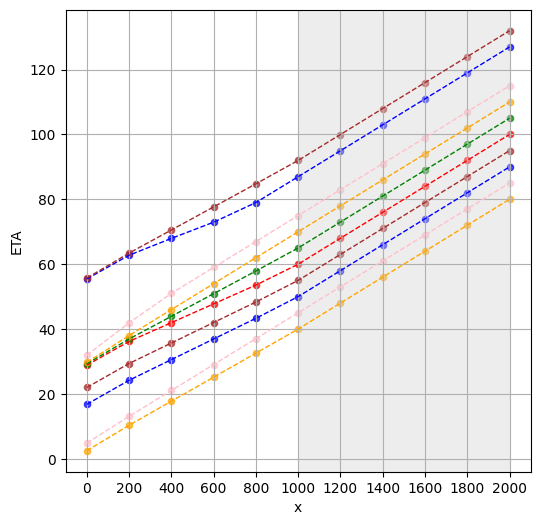

In [6]:
cwp_table.plot()

[{'ACC': 0, 'duration': 14.158084199964131, 'initial_speed': 20}, {'ACC': 2, 'duration': 2.5, 'initial_speed': 20}, {'ACC': 0, 'duration': 26.42380025283719, 'initial_speed': 25}]


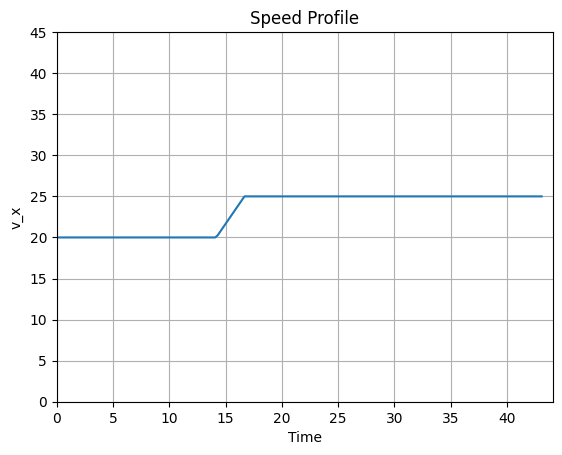

In [9]:
profile = CARS[7].speed_profile
print(profile)
CARS[7].plot_speed_profile()

In [11]:
profile = CARS[3].speed_profile
print(profile)
# CARS[3].plot_speed_profile()

[{'ACC': 0, 'duration': 28.729703548847652, 'initial_speed': 20}, {'ACC': 2, 'duration': 2.5, 'initial_speed': 20}, {'ACC': 0, 'duration': 14.765719011152342, 'initial_speed': 25}]


In [10]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 2])


    waypoint_idx       x         eta  car_idx  group_id  order_in_group
0              0     0.0   48.660000        2         0               2
1              1   200.0   55.980508        2         0               2
2              2   400.0   71.825423        2         0               2
3              3   600.0   79.825423        2         0               2
4              4   800.0   87.825423        2         0               2
5              5  1000.0   95.825423        2         0               2
6              6  1200.0  103.825423        2         0               2
7              7  1400.0  111.825423        2         0               2
8              8  1600.0  119.825423        2         0               2
9              9  1800.0  127.825423        2         0               2
10            10  2000.0  135.825423        2         0               2


In [1]:
cwp_table_controlled = cwp_table

NameError: name 'cwp_table' is not defined

In [75]:
cwp_table_kiss = cwp_table


In [7]:
# cwp_table.waypoint_table
df = cwp_table.waypoint_table
df[(df["group_id"] == 0) & (df["order_in_group"] == 0) & (df["waypoint_idx"] == 5)]["eta"].iloc[0]

40.016804311934614

In [7]:
a = None
a[0]

TypeError: 'NoneType' object is not subscriptable